### Parse single Tracefile 
You must change the location of the script dir if you want to use relative paths to the script.  
Or , set the absolute path to the tracefile.

In [21]:
import logging
import pandas as pd
import cx_Oracle
import matplotlib.pyplot as plt
import os
import re
#abspath = os.path.abspath(__file__)
#dname = os.path.dirname(abspath)
#os.chdir(f"{dname}/")
os.chdir("C:\\Users\\David Olivari\\Documents\\ONGOING DB WORK\\carsprd\\tracefiles_stuff\\bin")
os.getcwd()
sess_patt='^\*\*\* SESSION ID:\((\d+\.\d+)\) (.+)$'
re_sess=re.compile(sess_patt)
waits_patt="WAIT .+ nam\=\'(.+)\' ela= (\d+) .+ tim=(\d+)"
cursor_patt="PARSING IN CURSOR .+ tim=(\d+) hv=(\d+) .+ sqlid='(\w+)'"
re_sql=re.compile(cursor_patt)
re_waits=re.compile(waits_patt)
# space after char class necessary od numbers truncated
re_systime=re.compile('^.+tim=*([0-9]+) .+')
waits_cols = ['cursor_ts' ,'phv', 'sqlid', 'wait' , 'elapsed' , 'wait_ts']
sql_tuple=()
waits_list=[]
min_sys_ts=999999999999999999
max_sys_ts=0
#CARSPRD1_ora_49119.trc
#with open ('C:\\Users\\David Olivari\\.method-r\\sample\\CARSPRD1_ora_15948.trc') as fh:
with open ('C:\\Users\\David Olivari\\Documents\\ONGOING DB WORK\\carsprd\\tracefiles_stuff\\CARSPRD1_ora_49119.trc') as fh:
    for line in fh:
        #print(line)
        sid = re_sess.match(line)
        sql = re_sql.match(line)
        w = re_waits.match(line)
        sys_ts = re_systime.match(line)
        if sys_ts:
            t = int(sys_ts.groups(0)[0])
            if  min_sys_ts > t:
                min_sys_ts = t
            else:
                if max_sys_ts < t:
                    max_sys_ts = t
        if sid:
            #print(sid.groups(0))
            # sid and serial and when the session started
            sid_tuple = sid.groups(0)
        elif sql:
            sql_tuple=sql.groups(0)
        elif w:
            waits_list.append(sql_tuple + w.groups(0))
    waits = pd.DataFrame(waits_list,columns=waits_cols)
    waits['elapsed']=waits.elapsed.astype(int)
    # using float64 avoid c int32 overflow error
    waits['wait_ts']=waits.wait_ts.astype(float)
    waits['cursor_ts']=waits.cursor_ts.astype(float)
    print("All done")
    '''
      F I X     D A T A T Y P E S 
      
    '''
    

All done


In [3]:
waits.head()

,cursor_ts,phv,sqlid,wait,elapsed,wait_ts
0,1.626108e+15,1494628781,gfdbbs5cjcfdd,enq: TO - contention,113,1.626108e+15
1,1.626108e+15,1302841334,1mc9kn56ugjzq,library cache pin,109,1.626108e+15
2,1.626108e+15,3064780435,cv13ymyvatpnm,library cache pin,112,1.626108e+15
3,1.626108e+15,2254586991,1uu04zy364j3g,enq: TO - contention,117,1.626108e+15
4,1.626108e+15,2254586991,1uu04zy364j3g,library cache lock,113,1.626108e+15


In [22]:
waits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cursor_ts  733 non-null    float64
 1   phv        733 non-null    object 
 2   sqlid      733 non-null    object 
 3   wait       733 non-null    object 
 4   elapsed    733 non-null    int32  
 5   wait_ts    733 non-null    float64
dtypes: float64(2), int32(1), object(3)
memory usage: 23.0+ KB


## Plot waits for each sqlid
**Duration is on a log scale**

Text(0, 0.5, 'Duration uSecs')

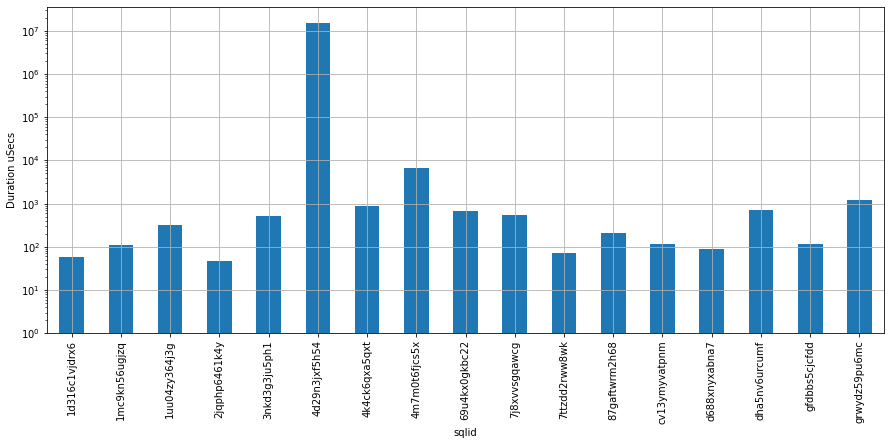

In [8]:
#waits.elapsed.sum()/1000000
df = waits.groupby(['sqlid']).sum()
#df.info()
ax= df['elapsed'].plot(kind='bar',
                   log=True,
                    grid =True,
                   figsize=(15,6))
ax.set_ylabel("Duration uSecs")

## Contribution of each Wait event for specific sqlid 
Enable log mode for a complete view of each event

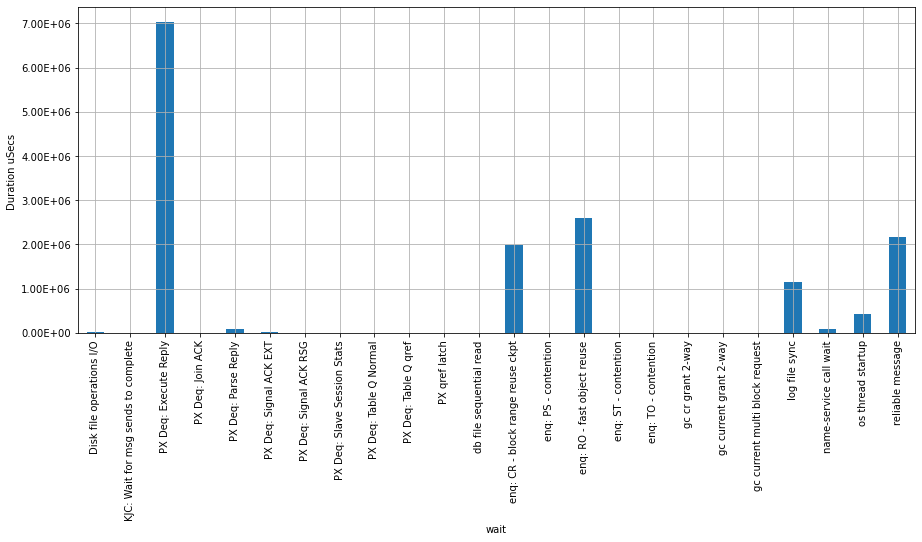

In [19]:
import matplotlib.ticker as tick
df2 = waits.loc[waits['sqlid']=='4d29n3jxf5h54']
grouped_waits = df2.groupby(['wait']).sum()
ax = grouped_waits['elapsed'].plot(kind='bar',
                              figsize=(15,6),
                              grid = True,
                                   #log-True,
                              rot=90)
ax.set_ylabel('Duration uSecs ')
y_fmt = tick.FormatStrFormatter('%2.2E')
ax.yaxis.set_major_formatter(y_fmt)

## Summary of top 5 events in sqlid execution

In [23]:
grouped_waits['elapsed_secs']=grouped_waits['elapsed']/1000000
summary=grouped_waits.sort_values(['elapsed_secs'],ascending=False).head(5)
summary[['elapsed_secs']]

,elapsed_secs
wait,
PX Deq: Execute Reply,7.028293
enq: RO - fast object reuse,2.602548
reliable message,2.157961
enq: CR - block range reuse ckpt,1.975823
log file sync,1.141278


## Session duration
Calculated using min and max tim found in trace

In [24]:
print((max_sys_ts - min_sys_ts)/1000000)


15.648147
